In [1]:
from sentence_transformers import CrossEncoder
model = CrossEncoder("cross-encoder/stsb-distilroberta-base")

In [ ]:
from guidance import models, gen, select
import guidance
language_model = 'TheBloke/CapybaraHermes-2.5-Mistral-7B-GPTQ'
lm = models.Transformers(language_model, device_map="cuda", echo=False)

In [ ]:
import os
script_dir = r"C:\Users\User\Desktop\Projects\Lucid\Random"
script_file_path = f'{script_dir}\\modified_file.txt'
with open(script_file_path, 'r') as input_file:
    script = input_file.read()
print(script[:500])

In [5]:
model.predict([["I hate my life","I love my life"]])

array([0.15719496], dtype=float32)

In [ ]:
script_list = script[2:].split(sep="\n\n- ")


In [ ]:
def create_sentence_groups(sentences, group_size=12):
    result_groups = []
    
    for i in range(0, len(sentences), group_size):
        group = sentences[i:i + group_size]
        
        if i > 0:
            # If not the first group, use the last two sentences of the previous group
            group[:2] = result_groups[-1][-2:] if len(result_groups[-1]) >= 2 else result_groups[-1]
        
        result_groups.append(group)
    
    # Check if the last group has fewer than 12 sentences
    #if len(result_groups[-1]) < group_size:
    #    # Leave the remaining sentences in the last group
    #    result_groups[-1] = sentences[len(result_groups) * group_size:]
    
    return result_groups

# Example usage:
sentences_list = [
    "Sentence 1", "Sentence 2", "Sentence 3", "Sentence 4",
    "Sentence 5", "Sentence 6", "Sentence 7", "Sentence 8",
    "Sentence 9", "Sentence 10", "Sentence 11", "Sentence 12",
    # Add more sentences as needed
]

result_groups = create_sentence_groups(script_list, group_size= 10)

# Print the result groups
for group in result_groups:
    print(group)
print(len(result_groups))


In [ ]:
conversation_chunk_list = []
for i in result_groups:
    conversation_chunk_list.append('- '+'\n- '.join(i))
print(conversation_chunk_list[0])

In [ ]:
summary_list = []

#for i in conversation_chunk_list:
i = conversation_chunk_list[0]
@guidance(stateless=True)
def write_summary(lm, conversation):
    prompt = f"""You are a helpful assistant.
Write a concise summary of the following conversation transcript:
{conversation}

CONCISE SUMMARY: {gen(name="Summary")}"""
    lm += prompt
    return lm

def get_summary(lm, conversation):
    lm+=write_summary(conversation=conversation)
    return lm['Summary']

for i in conversation_chunk_list:
    summary_list.append(get_summary(lm, i))

In [ ]:
import chromadb
client = chromadb.Client()
embedding_collection = client.get_or_create_collection('Summary')


In [ ]:
i = 1
for item in summary_list:
    embedding_collection.add(
        documents=[item],
        ids=[str(i)],
    )
    i += 1

In [ ]:
summary_embeddings = embedding_collection.get(include=['embeddings'])['embeddings']
print(summary_embeddings)

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
reducer = umap.UMAP()
reducer.fit(summary_embeddings)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

the_array = reducer.transform(summary_embeddings)
x_array = [point[0] for point in the_array]
y_array = [point[1] for point in the_array]

plt.scatter(x_array, y_array, c=range(len(x_array)), cmap='RdBu')

# Annotate each point with its number
for i, (x, y) in enumerate(zip(x_array, y_array)):
    plt.text(x, y, str(i + 1), fontsize=8, ha='right', va='bottom')

# Add lines and arrows indicating the directions with color gradient
colors = plt.cm.RdBu(np.linspace(0, 1, len(x_array) - 1))  # Generate a gradient from red to blue

for i in range(len(x_array) - 1):
    plt.arrow(x_array[i], y_array[i], x_array[i + 1] - x_array[i], y_array[i + 1] - y_array[i],
              color=colors[i], shape='full', lw=0.08, length_includes_head=True, head_width=0.1)

plt.show()


In [ ]:
plt.scatter(x_array, y_array)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

the_array = reducer.transform(summary_embeddings)
x_array = [point[0] for point in the_array]
y_array = [point[1] for point in the_array]

plt.scatter(x_array, y_array, c=range(len(x_array)), cmap='RdBu')

# Annotate each point with its number
for i, (x, y) in enumerate(zip(x_array, y_array)):
    plt.text(x, y, str(i + 1), fontsize=8, ha='right', va='bottom')

# Add lines and arrows indicating the directions with color gradient
colors = plt.cm.RdBu(np.linspace(0, 1, len(x_array) - 1))  # Generate a gradient from red to blue

for i in range(len(x_array) - 1):
    plt.arrow(x_array[i], y_array[i], x_array[i + 1] - x_array[i], y_array[i + 1] - y_array[i],
              color=colors[i], shape='full', lw=2, length_includes_head=True, head_width=0.15)

# Plot the distances between consecutive points
distances = [calculate_distance((x_array[i], y_array[i]), (x_array[i + 1], y_array[i + 1]))
             for i in range(len(x_array) - 1)]

# Apply moving average to smooth the distances
smoothed_distances = moving_average(distances, 5)

plt.figure()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.plot(range(1, len(smoothed_distances) + 1), smoothed_distances, linestyle='-', color='black')
plt.xlabel('Point Pair')
plt.ylabel('Inverted Smoothed Distance')
plt.title('Inverted Smoothed Distances between Consecutive Points')
plt.show()


In [ ]:
result_list = model.predict([[summary_list[i], summary_list[i+1]] for i in range(len(summary_list)-1)])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x= np.array(range(1, len(result_list)+1))
y= np.array(result_list)

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')
window_size = 3

plt.plot(np.array(range(1, len(moving_average(y, window_size))+1)), moving_average(y, window_size))

In [ ]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
embedding_function = SentenceTransformerEmbeddingFunction()
client = chromadb.Client()

In [ ]:
import umap
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit()

In [2]:
import vec2text
corrector = vec2text.load_corrector("gtr-base")

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
vec2text.invert_strings(
    [
        "Jack Morris is a PhD student at Cornell Tech in New York City",
        "It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity"
    ],
    corrector=corrector,
    num_steps=20,
)

['Jack Morris Morris is a PhD student at  Cornell Tech in New York City ',
 'It was the best of times, it was the worst of times, it was the age of wisdom, it was the epoch of foolishness']

In [ ]:
vec2text.invert_embeddings(
    
)

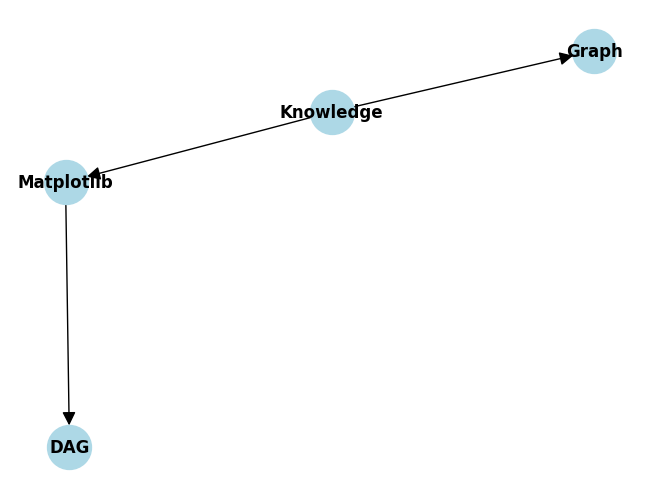

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed acyclic graph (DAG)
G = nx.DiGraph()

# Add nodes
nodes = ["Knowledge", "Graph", "Matplotlib", "DAG"]
G.add_nodes_from(nodes)

# Add edges
edges = [("Knowledge", "Graph"), ("Knowledge", "Matplotlib"), ("Matplotlib", "DAG")]
G.add_edges_from(edges)

# Define the layout for the graph
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=1000, node_color='lightblue', arrowsize=20)

